In [1]:
import os,shutil
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import numpy as np

# Helpers
from SimEx.Utilities.Units import meter, electronvolt, joule, radian

# PMI
from SimEx.Calculators.XMDYNDemoPhotonMatterInteractor import XMDYNDemoPhotonMatterInteractor

# Simple Beam Parameters
from SimEx.Parameters.PhotonBeamParameters import PhotonBeamParameters

# Diffraction
from SimEx.Parameters.DetectorGeometry import DetectorGeometry, DetectorPanel
from SimEx.Parameters.SingFELPhotonDiffractorParameters import SingFELPhotonDiffractorParameters
from SimEx.Calculators.SingFELPhotonDiffractor import SingFELPhotonDiffractor

# Analysis
from SimEx.Analysis.XFELPhotonAnalysis import XFELPhotonAnalysis
from SimEx.Analysis.DiffractionAnalysis import DiffractionAnalysis

import matplotlib.colors as colors

initializing ocelot...



## Data path setup

In [2]:
data_path = '../../../data/simulation/'

## Beam

In [3]:
beam = PhotonBeamParameters(
            photon_energy=18.86e3 * electronvolt,
            beam_diameter_fwhm=1.0e-6 * meter,
            pulse_energy=1.0e-3 * joule,
        )

## Detector Setting

In [4]:
p0 = DetectorPanel(
            ranges={
                'fast_scan_min': 0,
                'fast_scan_max': 100,
                'slow_scan_min': 0,
                'slow_scan_max': 200
            },
            pixel_size=220e-6 * meter,
            photon_response=1.0,
            distance_from_interaction_plane=0.13 * meter,
            corners={
                'x': -50,
                'y': 1
            },
            fast_scan_xyz = '1.0x',
            slow_scan_xyz = '1.0y'
        )
p1 = DetectorPanel(
            ranges={
                'fast_scan_min': 0,
                'fast_scan_max': 100,
                'slow_scan_min': 0,
                'slow_scan_max': 200
            },
            pixel_size=220e-6 * meter,
            photon_response=1.0,
            distance_from_interaction_plane=0.13 * meter,
            corners={
                'x': -50,
                'y': -201
            },
            fast_scan_xyz = '1.0x',
            slow_scan_xyz = '1.0y'
        )
detector_geometry = DetectorGeometry(panels=[p0,p1])

In [5]:
detector_geometry.serialize()

;panel 0
panel0/min_fs         = 0
panel0/max_fs         = 100
panel0/min_ss         = 0
panel0/max_ss         = 200
panel0/corner_y       = 1
panel0/fs             = 1.0x
panel0/ss             = 1.0y
panel0/clen           = 1.3000000e-01
panel0/res            = 4.5454545e+03
panel0/coffset        = 0.0000000e+00
panel0/adu_per_photon = 1.0000000e+00
panel0/max_adu        = 1.0000000e+04
panel0/px             = 101
panel0/py             = 201
panel0/pix_width      = 2.2000000e-04
panel0/d              = 1.3000000e-01
panel0/corner_x       = -50

;panel 1
panel1/min_fs         = 0
panel1/max_fs         = 100
panel1/min_ss         = 0
panel1/max_ss         = 200
panel1/corner_y       = -201
panel1/fs             = 1.0x
panel1/ss             = 1.0y
panel1/clen           = 1.3000000e-01
panel1/res            = 4.5454545e+03
panel1/coffset        = 0.0000000e+00
panel1/adu_per_photon = 1.0000000e+00
panel1/max_adu        = 1.0000000e+04
panel1/px             = 101
panel1/py             = 20

## Clean up previous diffraction run

In [6]:
dirs_to_remove=['diffr']
files_to_remove=['diffr.h5']

for d in dirs_to_remove:
    if os.path.isdir(d):
        shutil.rmtree(d)
for f in files_to_remove:
    if os.path.isfile(f):
        os.remove(f)

## Diffractor Settings

In [7]:
diffraction_parameters = SingFELPhotonDiffractorParameters(
                                               uniform_rotation=False,
                                               slice_interval=1,
                                               number_of_slices=1,
                                               number_of_diffraction_patterns=2,
                                               detector_geometry=detector_geometry,
                                               beam_parameters = beam,
                                               forced_mpi_command='mpirun -np 1',
                                              )

In [8]:
diffractor = SingFELPhotonDiffractor(parameters=diffraction_parameters,
                                     input_path='3WUL.pdb',
                                     output_path="diffr")

In [9]:
diffractor._run()
diffractor.saveH5()

In [10]:
H5Glance('diffr/diffr_out_0000001.h5')

In [11]:
H5Glance('diffr.h5')

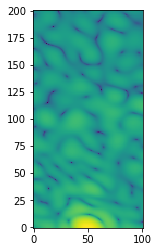

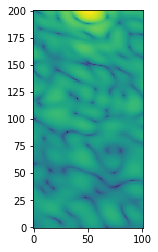

In [12]:
with h5py.File('diffr.h5','r') as f:
    for i,iteration in enumerate(f['data']):
        if i < 1:
            data = f['data'][iteration]['panel_00']['data'][...]
            diffr = f['data'][iteration]['panel_00']['diffr'][...]
            plt.figure()
            plt.imshow(diffr,norm=colors.LogNorm(vmin=diffr.min(), vmax=diffr.max()),origin='lower')
            diffr = f['data'][iteration]['panel_01']['diffr'][...]
            plt.figure()
            plt.imshow(diffr,norm=colors.LogNorm(vmin=diffr.min(), vmax=diffr.max()),origin='lower')

## Poisson noise

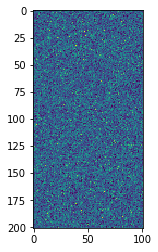

In [13]:
poisson_noise = np.random.poisson(lam=5, size=diffr.shape)
plt.imshow(poisson_noise)

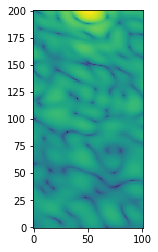

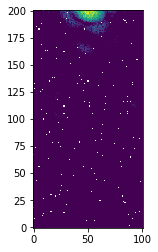

In [14]:
poisson_noise = np.random.poisson(lam=5, size=diffr.shape)

plt.imshow(diffr,norm=colors.LogNorm(vmin=diffr.min(), vmax=diffr.max()),origin='lower')
data = diffr*poisson_noise
plt.figure()
plt.imshow(data,norm=colors.LogNorm(vmin=data.min()+0.00001, vmax=data.max()),origin='lower')

## inf noise

In [15]:
# poisson_noise = np.random.poisson(lam=5, size=diffr.shape)
# plt.imshow(poisson_noise)
# np.Inf

ran_x = np.random.randint(diffr.shape[0],size=50)
ran_y = np.random.randint(diffr.shape[1],size=50)

for x,y in zip(ran_x,ran_y):
    diffr[x,y] = np.random.randint(low=-1,high=2)*np.Inf

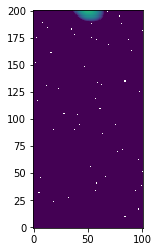

In [16]:
plt.figure()
plt.imshow(diffr,norm=colors.LogNorm(vmin=data.min()+0.00001, vmax=data.max()),origin='lower')